## Contrastive pre-training

**Student: Lucas Versini**

Here, we will try the SimCLR method.

[1] T. Chen et al. “A Simple Framework for Contrastive Learning of Visual Representations”. In: ICML. 2020.


In [1]:
import os
import shutil
import yaml
import logging
import sys
import zipfile
from copy import deepcopy


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

## Torchvision
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.datasets import STL10, PCAM
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn

## Plot Options
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
plt.set_cmap("cividis")
%matplotlib inline
sns.set_theme()

## SKlearn
from sklearn.linear_model import LogisticRegression


# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)


try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
  import gdown
except:
  IN_COLAB = False
  import gdown

Hfactory=False # put equal to True, if you are using HFactory
if Hfactory:
    !pip install gdown==4.6.0 # with the following versions, there is an error  
    !pip uninstall -y h5py
    !pip install h5py
    import h5py


Number of workers: 16


<Figure size 640x480 with 0 Axes>

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = torch.device("cuda:0") # we use one GPU, the first one
    print ("CUDA device found.")
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.6.0+cu124
CUDA device found.


### Data Augmentation for Contrastive Learning

One of the key points of SimCLR is the choice of the augmentation strategy. It composes many different geometric and iconographic transformations.
We can implement them very efficiently and easily using the Dataset object of Pytorch.

Since in SimCLR authors use 2 views, we do the same here. Please note that we could use more positives

The transformations used are: (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_data_augmentations.jpg" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

When using ImageNet-derived datasets, the two most important transformations are: crop-and-resize, and color distortion.
Interestingly, they need to be used together since, when combining randomly cropping and resizing, we might have two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in the representation space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view.
However, the network can use the color information (color histograms) to create a useless link between the two patches, without learning generalizable high-level representations. For instance, it could focus on the color of the fur of the dog and on the color of the background to understand that the two patches belong to the same image. That's why, we need to compose crop-and-resize and color distortion.

**Question**: Create a Pytorch class of transformations (transforms.Compose) where you apply the following augmentations:
- Resize an Crop
- Horizontal Flip
- Color jittering
- Gray scale changes
- Gaussian Blur

Hint: all functions have already been implemented and can be found here: https://pytorch.org/vision/0.9/transforms.html

Alternatively, you can also use [albumentations](https://albumentations.ai/) by simply adding:

`import albumentations as A`

`from albumentations.pytorch.transforms import ToTensorV2`

In [3]:
class ContrastiveTransformations:
    def __init__(self, img_size, s=1):
      # transformations applied in SimCLR article
      self.data_transform = transforms.Compose([
              transforms.RandomResizedCrop(size=img_size),
              transforms.RandomHorizontalFlip(),
              transforms.RandomApply([transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)], p = 0.8),
              transforms.RandomGrayscale(p = 0.2),
              transforms.RandomApply([transforms.GaussianBlur(kernel_size = int(0.1 * img_size))], p = 0.5),
              transforms.ToTensor(),
              transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                   std = [0.229, 0.224, 0.225])
          ])

    def __call__(self, x):
      # it outputs a tuple, namely 2 views (augmentations) fo the same image
      return self.data_transform(x), self.data_transform(x)

In [4]:
# simple transformation to use networks pre-trained on ImageNet
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

**Question**: What's the difference between `ContrastiveTransformations` and `img_transforms` ? Look inside the functions and their outputs...

**Answer**:

- `ContrastiveTransformations` applies a series of transformations (resize and crop, flip, color jittering, gray scale changes, gaussian blur) to an image twice to obtain two transformations of the input image, then used to train the model on contrastive learning. It also normalizes the images and turns them into tensors.

- `img_transforms` simply turns the images into tensors and normalizes them. It does not perform augmentation techniques, and outputs a single transformed image (and not two).

So `ContrastiveTransformations` is used for contrastive learning by creating augmented versions of the input image, whereas `img_transforms` is simply used to make the images suitable for a model trained on ImageNet.

In [5]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [6]:
if IN_COLAB:
    #data_directory="./" # decomment it if you do NOT use Google Drive
    data_directory="/content/drive/MyDrive/TP/"  # decomment it if you USE Google Drive and copy/paste the path to your Google Drive
elif Hfactory:
    data_directory="./"    
else:
    data_directory="data/" # copy/paste the path of the folder with STL dataset in your computer

We create unlabeled, training and test Datasets.
Please be careful since we use two different transformations, one for the unlabelled part and one for train/test set.

In [7]:
unlabeled_dataset_2viewsCon = STL10(root=data_directory+"data", split="unlabeled", download=True, transform=ContrastiveTransformations(96))
train_dataset = STL10(root=data_directory+"data", split="train", download=True, transform=img_transforms)
# just to show the effect of the augmentations and the classes
train_dataset_2viewsCon = STL10(root=data_directory+"data", split="train", download=True, transform=ContrastiveTransformations(96))
test_dataset = STL10(root=data_directory+"data", split="test", download=True, transform=img_transforms)

In [8]:
# To check the classes in STL10
classes=unlabeled_dataset_2viewsCon.classes
print(classes)
print('Number images in Unlabeled dataset:' ,len(unlabeled_dataset_2viewsCon))
print(unlabeled_dataset_2viewsCon[0][0][0].shape) # this is one image (the first of the 2-views tuple)

# Train dataset
labels=train_dataset.labels # retrieve label of each sample
print('Number images in Train dataset:' , len(train_dataset)) # retrieve length of dataset
print(train_dataset[3][0].shape) # this is one image

#Test dataset
print('Number images in Test dataset:' ,len(test_dataset))
print(test_dataset[0][0].shape) # this is one image

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number images in Unlabeled dataset: 100000
torch.Size([3, 96, 96])
Number images in Train dataset: 5000
torch.Size([3, 96, 96])
Number images in Test dataset: 8000
torch.Size([3, 96, 96])


The Unlabeled dataset contains 100k images. Here, to limit memory requirement, we will use 10% of the data.

In [9]:
sizeUnlabelled=10000 # 10 % of the unlabeled dataset

unlabeled_dataset_2viewsCon_red,rest = random_split(unlabeled_dataset_2viewsCon, [sizeUnlabelled, len(unlabeled_dataset_2viewsCon)-sizeUnlabelled])
len(unlabeled_dataset_2viewsCon_red)
del unlabeled_dataset_2viewsCon # free memory

We can also create a function to visualize the views of each sample, based on the chosen augmentation strategy.

In [10]:
def imshowSTL102views(datasetOrig,datasetTransform,rows=5,figsize=(8, 15)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, 3*(rows-1)+2,3):
      imgOrig = datasetOrig[i][0]
      img1=datasetTransform[i][0][0]
      img2=datasetTransform[i][0][1]

      #REMOVE NORMALIZATION
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
      # Clip values to range [0,1] -> possible rounding errors during normalization
      imgOrig = np.clip(unnormalize(imgOrig).numpy(),0,1)
      img1 = np.clip(unnormalize(img1).numpy(),0,1)
      img2 = np.clip(unnormalize(img2).numpy(),0,1)

      label = datasetOrig[i][1]
      fig.add_subplot(rows, 3, i)
      plt.title(datasetOrig.classes[label]+ ' , original')
      plt.imshow(np.transpose(imgOrig, (1, 2, 0)))
      plt.axis("off")
      fig.add_subplot(rows, 3, i+1)
      plt.title(datasetOrig.classes[label] + ' , 1st view')
      plt.imshow(np.transpose(img1, (1, 2, 0)))
      plt.axis("off")
      fig.add_subplot(rows, 3, i+2)
      plt.title(datasetOrig.classes[label] + ' , 2nd view')
      plt.imshow(np.transpose(img2, (1, 2, 0)))
      plt.axis("off")
    plt.show()

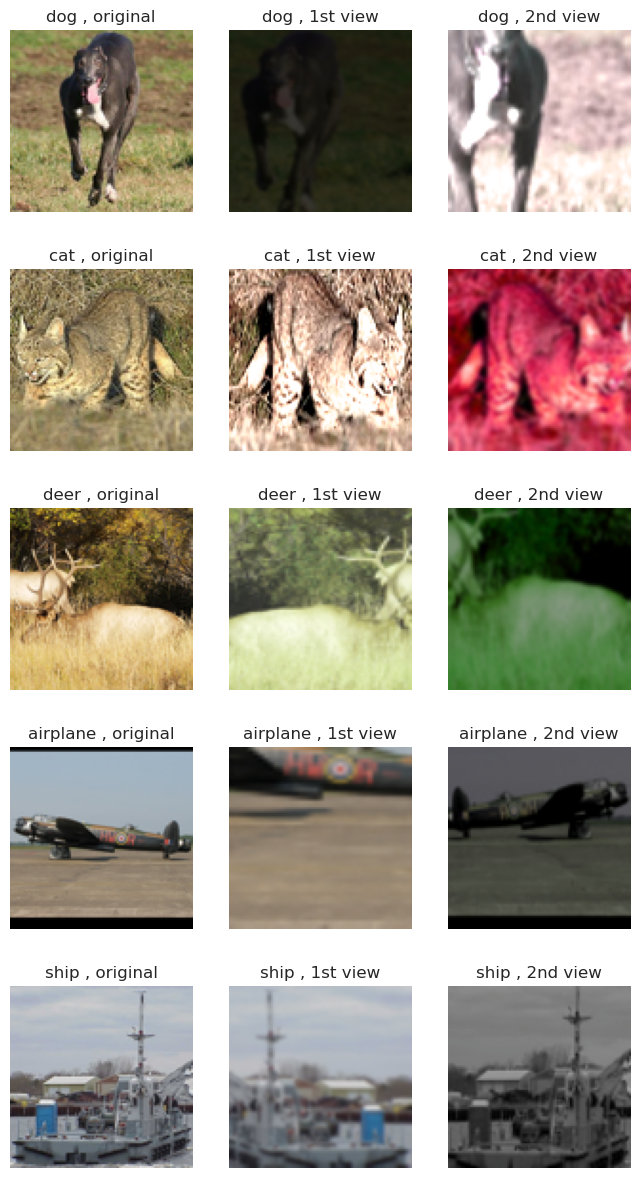

In [11]:
imshowSTL102views(train_dataset,train_dataset_2viewsCon)

In [12]:
del train_dataset_2viewsCon # To free memory

Here, it's the most important part of the code.

I remind you that the Siamese architecture of SimCLR is: (figure credit - [Ting Chen et al. ](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_network_setup.svg" width="350px"></center>

The employed loss is the InfoNCE loss:
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$
where $\tau$ is the temperature and the similarity measure is the cosine similarity:
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$
The maximum cosine similarity possible is $1$, while the minimum is $-1$.

After training, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor.


**Question**: Comment the code where you see **XXXXXXXXXXXXXXXXXX** explaining in details what the code is doing.

PS: if you are using a MacBook, you might have issues with multiprocessing. In that case, please use Google Colab.

In [13]:
class SimCLR():

    def __init__(self, model, optimizer, scheduler, device, batch_size, temperature, epochs):
        self.device=device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.temperature=temperature
        self.batch_size=batch_size
        self.epochs=epochs


    def info_nce_loss(self, features):

        # Create labels for contrastive learning
        # labels[i, j] is 1 if i = j [same image] or if j = (i + 3) % batch_size [two images obtained from a same image], else 0
        labels = torch.cat([torch.arange(self.batch_size) for i in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = F.normalize(features, dim=1) # Normalize feature vectors to compute cosine similarity (dot product since vectors are normalized)

        # Compute the similarity matrix between all feature vectors: similarity_matrix[i, j] = features[i] * features[j] (dot product)
        similarity_matrix = torch.matmul(features, features.T)

        # Remove the diagonal from the matrix (similarity of a vector with itself is always 1)
        # mask is the identity matrix (boolean); ~mask is its negation; labels[~mask] removes diagonal elements; then we reshape the labels and the similarity matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        # Extract positive pairs (same images with different augmentations)
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # Extract negative pairs (different images in the batch)
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        # Concatenate positives and negatives to form logits for contrastive loss
        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        # Divide logits by temperature to scale the dot product similarity scores
        logits = logits / self.temperature
        return logits, labels

    def train(self, train_loader, use_amp = False):
    
        # Initialize the GradScaler if using mixed-precision training
        scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None

        n_iter = 0
        print("Start SimCLR training for {} epochs.".format(self.epochs))

        for epoch_counter in range(self.epochs):
            for images, _ in tqdm(train_loader):
                # Concatenate the two views of the images along the batch dimension, and move to the device
                images = torch.cat(images, dim=0)
                images = images.to(self.device)

                if torch.cuda.is_available() and use_amp:
                  with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp): # to improve performance while maintaining accuracy. 
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)
                else:   #autocast and mixed-precision training with FP16 is not suited for CPU                           
                  features = self.model(images)
                  logits, labels = self.info_nce_loss(features)
                  # Compute the contrastive loss using the logits and labels
                  loss = self.criterion(logits, labels)     

                self.optimizer.zero_grad()

                if scaler is not None:
                  scaler.scale(loss).backward()
                  scaler.step(self.optimizer)
                  scaler.update()
                else:
                  loss.backward()
                  self.optimizer.step()

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 5:
                self.scheduler.step()

            print('Epoch: {}, Average loss: {:.4f}, lr: {:.4f}'.format(epoch_counter, loss / len(train_loader.dataset), self.scheduler.get_last_lr()[0] ))

        print("Training has finished.")

As before, we use a DataLoader.

DataLoader wraps an iterable around the Dataset to enable easy access to the samples. The Dataset retrieves our dataset features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.


In [14]:
bs = 256 # choose an appropriate batch size depending on the computational resources

train_unlabelled_loader = DataLoader(dataset=unlabeled_dataset_2viewsCon_red, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True, persistent_workers=True)

Here we define the hyper-parameters, optimization, scheduler and launch the training.

**Question**: complete the code where you see XXXXX.

As model for $f()$, use a ResnNet18 not-pretrained. Remember that the model ResNet18 has already a Linear Layer at the end (fc) which can be written as $Wf(x)$. You can also change the `out_features` of the fc by adding the option `num_classes=XXXX` while loading the model.

 As projection head, use the one from the article

 $$ g(f(x))=W^a \sigma (W^b f(x))$$

 where $\sigma$ is a Relu non-linearity.

In [15]:
max_epochs=2
lr=0.003
wd=1e-4
temperature=0.07
#f_dim=512 # to use if you want to change the output dimension of f
g_dim=128 # the output dimension of the projection head

# Ensure that you are using GPU and all CPU workers
print("Device:", device)

# Encoder f
f = models.resnet18(weights = None) # Wf()
f_dim = f.fc.in_features

# Projection head g()
g = nn.Sequential(nn.Linear(f_dim, g_dim), nn.ReLU(), nn.Linear(g_dim, g_dim))
f.fc = g # add the projection head

optimizer = torch.optim.Adam(f.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_unlabelled_loader), eta_min=0, last_epoch=-1)

Device: cuda:0


In [16]:
simclr = SimCLR(model=f, optimizer=optimizer, scheduler=scheduler, device=device, batch_size=bs, temperature=temperature, epochs=max_epochs)

if torch.cuda.is_available():
    simclr.train(train_unlabelled_loader, use_amp = True)
else:
    simclr.train(train_unlabelled_loader, use_amp = False)

# save model checkpoints
os.makedirs('models/', exist_ok=True)
filename = 'models/resnet18_simclr_2epochs_stl10.pth.tar'
torch.save({
                'epoch': max_epochs,
                'state_dict': simclr.model.state_dict()
            }, filename)

/tmp/ipykernel_3733070/3445154744.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Start SimCLR training for 2 epochs.


100%|██████████| 39/39 [00:05<00:00,  6.82it/s]


Epoch: 0, Average loss: 0.0006, lr: 0.0030


100%|██████████| 39/39 [00:04<00:00,  7.95it/s]


Epoch: 1, Average loss: 0.0006, lr: 0.0030
Training has finished.


To continue, you can use a model that I have already pre-trained for 100 epochs.

In [17]:
model_path = 'models/resnet18_simclr_100epochs_stl10.pth.tar'

if os.path.isfile(data_directory+model_path):
    print("pre-trained model already downloaded")
else:
    import gdown
    print("downloading the pre-trained model")
    os.makedirs(data_directory+'models/', exist_ok=True)
    file_url = 'https://drive.google.com/uc?id=13_ZueA9mqh17GvYVkfU_Yokg3z065rKG'    
    gdown.download(file_url, data_directory+model_path)


# Load checkpoint file of already trained model
checkpoint = torch.load(data_directory+model_path, map_location=torch.device(device))

# Load Model parameters and set it into eval mode
model_download = models.resnet18(weights=None) # we will only use f and not g
model_download.load_state_dict(checkpoint['state_dict'], strict=False)

epoch = checkpoint['epoch']

pre-trained model already downloaded


As previously explained, we can now use $f()$ to encode the samples discarding $g()$.

**Question** How can you discard the projection ? Complete the code.

**Answer**:

We discard the projection by setting `model.fc = nn.Identity()`.

In [18]:
@torch.no_grad()
def prepare_data_features(model, dataset, batchsize,  device):
    # Prepare model
    network = deepcopy(model)

    # you need to modify network here
    network.fc = nn.Identity() # remove the classification head
    
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=batchsize, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)

    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels), [feats.numpy() , labels.numpy()]

We can use either the trained model or the downloaded model and encode the train and test images.

In [19]:
modelTrained=simclr.model
# modelTrained=model_download
trainloader, [train_feats, train_labels] = prepare_data_features(modelTrained, train_dataset, batchsize=bs, device=device)
testloader, [test_feats, test_labels] = prepare_data_features(modelTrained, test_dataset, batchsize=bs, device=device)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

100%|██████████| 32/32 [00:01<00:00, 21.07it/s]

(5000, 512) (5000,)
(8000, 512) (8000,)


**Linear Probe**:  we train a logistic regression on the train dataset and evaluate it on the test dataset. This is called Linear Probe.

**Question**: compute the training and test error using a logistic regression where you are free to use a regularization.

In [20]:
# compute linear probe results

def linear_probe(train_feats, train_labels, test_feats, test_labels):
    model = LogisticRegression(max_iter = 3000, C = 1e-1, random_state = 42)

    model.fit(train_feats, train_labels)

    acc_train = model.score(train_feats, train_labels)
    acc_test = model.score(test_feats, test_labels)

    return acc_train, acc_test

acc_train, acc_test = linear_probe(train_feats, train_labels, test_feats, test_labels)
print("Accuracy on the train set:", acc_train)
print("Accuracy on the test set:", acc_test)

Accuracy on the train set: 0.4476
Accuracy on the test set: 0.39475


What if we simply used it a pre-trained model on ImageNet ? ...

**Question**: use the previous function `prepare_data_features` with a resnet18 pre-trained on Imagenet and compute the Linear Probe as before.

In [21]:
# pretrained
modelImageNet = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
modelImageNet.fc = nn.Identity() # remove the classification head

trainloader_imagenet, [train_feats_imagenet, train_labels_imagenet] = prepare_data_features(modelImageNet, train_dataset, batchsize=256, device=device)
testloader_imagenet, [test_feats_imagenet, test_labels_imagenet] = prepare_data_features(modelImageNet, test_dataset, batchsize=256, device=device)

acc_train_imagenet, acc_test_imagenet = linear_probe(train_feats_imagenet, train_labels_imagenet, test_feats_imagenet, test_labels_imagenet)
print("\nAccuracy on the train set with ImageNet features:", acc_train_imagenet)
print("Accuracy on the test set with ImageNet features:", acc_test_imagenet)

100%|██████████| 32/32 [00:01<00:00, 30.11it/s]



Accuracy on the train set with ImageNet features: 1.0
Accuracy on the test set with ImageNet features: 0.867625


**Question**: is the result better ? Why in your opinion ? What could you do to improve the method with the worst result ?



**Answer**:
The result is indeed better using a model pretrained on ImageNet. This is because ImageNet pre-training provides features that are general and useful, which come from learning on millions of images.

Model | Train accuracy | Test accuracy
--- | --- | ---
Trained for 2 epochs | 45 % | 39 %
Trained for 100 epochs (downloaded) | 52 % | 48 %
ImageNet features | 100 % | 87 %

To improve the first model (the one not pretrained on ImageNet), we could for instance:
- Tune some hyperparameters (learning rate, number of epochs, etc.)
- Use a stronger data augmentation strategy
- Use another backbone

To go further, you could use one of the datasets present in Med Mnist (https://medmnist.com/). These are real but rescaled images. Small images allow the training of DL models on small GPU but we loose resolution and thus clinically relevant information. 

Otherwise, you could use the PatchCamelyon dataset (https://www.kaggle.com/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon), which comprises real and large images.

The PatchCamelyon benchmark is a image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue.

You can donwload it from pytorch vision or, if you are using Google Colab, directly from our Google drive. The pytorch version needs to be unzipped and there is not enough RAM memory in the Google Colab servers...

Please do not change the following code.

In [22]:
os.makedirs(data_directory+"data/pcam", exist_ok=True)

# Download the Train set
file_url = 'https://drive.google.com/uc?id=1ipIG12YWag54v2_2JIyfPiZDN0Eu3IjB'
train_path = 'camelyonpatch_level_2_split_train_x.h5'
if os.path.isfile(data_directory+"data/pcam/"+train_path):
    print("training set already downloaded")
else:
    print("downloading training set")
    gdown.download(file_url, data_directory+"data/pcam/"+train_path, quiet=False)

# Download Valid set
file_url = 'https://drive.google.com/uc?id=1emdhTV8J8Pv-SjKSoMzE_SbT04Ik2yUm'
valid_path = 'camelyonpatch_level_2_split_valid_x.h5'
if os.path.isfile(data_directory+"data/pcam/"+valid_path):
    print("validation set already downloaded")
else:
    print("downloading validation set")
    gdown.download(file_url, data_directory+"data/pcam/"+valid_path, quiet=False)

# Download Test set
file_url = 'https://drive.google.com/uc?id=1dkeFapKSKm-wUtf9zicxiSHWIS0uxv8Z'
test_path = 'camelyonpatch_level_2_split_test_x.h5'
if os.path.isfile(data_directory+"data/pcam/"+test_path):
    print("test set already downloaded")
else:
    print("downloading test set")
    gdown.download(file_url, data_directory+"data/pcam/"+test_path, quiet=False)

# Download the labels
file_url = 'https://drive.google.com/uc?id=10ftBj2ZiiDESTsANdF-v8oh4NieinYPP'
labels_path = 'Label.zip'
if os.path.isfile(data_directory+"data/pcam/camelyonpatch_level_2_split_test_y.h5"):
    print("Labels already downloaded")
else:
    print("downloading labels")
    gdown.download(file_url, data_directory+"data/pcam/"+labels_path, quiet=False)
    # Unzip and move to data directory
    with zipfile.ZipFile(data_directory+"data/pcam/"+labels_path, 'r') as zip_ref:
        zip_ref.extractall(data_directory+"data/pcam/")
    # Moving files
    os.rename(data_directory+"data/pcam/Labels/camelyonpatch_level_2_split_test_y.h5", data_directory+"data/pcam/camelyonpatch_level_2_split_test_y.h5")
    os.rename(data_directory+"data/pcam/Labels/camelyonpatch_level_2_split_train_y.h5", data_directory+"data/pcam/camelyonpatch_level_2_split_train_y.h5")
    os.rename(data_directory+"data/pcam/Labels/camelyonpatch_level_2_split_valid_y.h5", data_directory+"data/pcam/camelyonpatch_level_2_split_valid_y.h5")
    # Cleaning
    os.remove(data_directory+"data/pcam/"+labels_path)
    os.rmdir(data_directory+"data/pcam/Labels")

training set already downloaded
validation set already downloaded
test set already downloaded
Labels already downloaded


Now you can load it using the PCAM Dataset and DataLoader (keep download as False since you have already downloaded the data)

In the following, you will use the training split as if it was unlabeled, thus for the self-supervised part, then the val split as if it was the training set and the test split as test set.

In [23]:
img_size=96
bs = 128

# ### PCAM Dataset

PCAM_unlabeled_dataset = PCAM(root=data_directory+"data", download=False, split='train', transform=ContrastiveTransformations(img_size))
PCAM_train_dataset = PCAM(root=data_directory+"data", download=False, split='val', transform=transforms.ToTensor())
PCAM_test_dataset = PCAM(root=data_directory+"data", download=False, split='test', transform=transforms.ToTensor())
print('There are: ', len(PCAM_unlabeled_dataset), 'training images; ', len(PCAM_train_dataset), ' validation images; and ', len(PCAM_test_dataset), ' test images')


PCAM_unlabeled_loader = DataLoader(dataset=PCAM_unlabeled_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True)
PCAM_train_loader = DataLoader(PCAM_train_dataset, batch_size=bs)
PCAM_test_loader = DataLoader(PCAM_test_dataset, batch_size=bs)


There are:  262144 training images;  32768  validation images; and  32768  test images


We can visualize the images as before

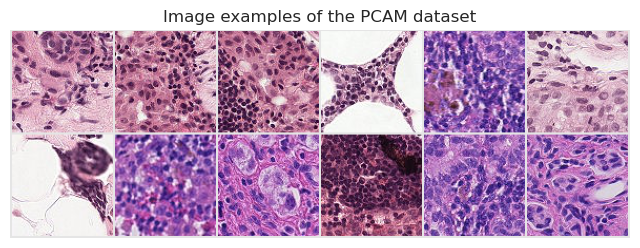

In [24]:
# Visualize some examples
NUM_IMAGES = 12
PCAM_images = torch.stack([PCAM_train_dataset[np.random.randint(len(PCAM_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(PCAM_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the PCAM dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

**Question**: As before, train the SimCLR algorithm on the unlabeled set and then train and test the Linear Probe.

This time, you can use the ResNet-18 pre-trained on ImageNet and train it for just 10 epochs.
If you want to speed up the computations (a bit) you can also reduce the size of the images


In [25]:
max_epochs=10
lr=0.003
wd=1e-4
temperature=0.07


model = models.resnet18(weights=None, num_classes=128)
dim_mlp = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), model.fc)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(PCAM_unlabeled_loader), eta_min=0, last_epoch=-1)

simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, device=device, batch_size=bs, temperature=temperature, epochs=max_epochs)
simclr.train(PCAM_unlabeled_loader)

# save model checkpoints
os.makedirs('models/', exist_ok=True)
filename = 'models/resnet18_simclr_100epochs_PCAM.pth.tar'
torch.save({
                'epoch': max_epochs,
                'state_dict': simclr.model.state_dict()
            }, filename)

/tmp/ipykernel_3733070/3445154744.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Start SimCLR training for 10 epochs.


100%|██████████| 2048/2048 [03:14<00:00, 10.51it/s]


Epoch: 0, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:14<00:00, 10.52it/s]


Epoch: 1, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:14<00:00, 10.51it/s]


Epoch: 2, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:14<00:00, 10.52it/s]


Epoch: 3, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:38<00:00,  9.36it/s]


Epoch: 4, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:45<00:00,  9.07it/s]


Epoch: 5, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:45<00:00,  9.06it/s]


Epoch: 6, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:46<00:00,  9.05it/s]


Epoch: 7, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:44<00:00,  9.11it/s]


Epoch: 8, Average loss: 0.0000, lr: 0.0030


100%|██████████| 2048/2048 [03:45<00:00,  9.07it/s]


Epoch: 9, Average loss: 0.0000, lr: 0.0030
Training has finished.


**Question**: Using the linear probe, test whether the self-supervised training (for 10 or more epochs) improves the results over a simple ResNet18 only pre-trained on ImageNet. What would you do if you had more time ?

**Answer**:
The results are shown in the table below.

Model | Train accuracy | Test accuracy
--- | --- | ---
SSL (10 epochs) | 84 % | 79 %
ImageNet | 86 % | 77 %

On the training dataset, the ImageNet model performs better, and on the test dataset, the SSL model performs better.

Note that here, the ImageNet model was not trained on the training dataset (so it did not simply overfit).

So our model is quite good (it performs better on some data it has never seen before).

Obviously, once again we could tune hyperparameters (number of epochs, learning rate, optimizer, temperature, etc.). If I had enough computational power, I would use a more sophisticated model.

We could also use features from several layers at the same time, to have a hierarchical representation.

We could also use something else than than Logistic regression (SVM, MLP, etc.).

Then, to better understand the results we obtain, we could visualize (using PCA, t-SNE to have a look at the features, or Grad-CAM to see what the model learns).

In [26]:
modelTrained = simclr.model
trainloader, [train_feats, train_labels] = prepare_data_features(modelTrained, PCAM_train_dataset, batchsize=256, device=device)
testloader, [test_feats, test_labels] = prepare_data_features(modelTrained, PCAM_test_dataset, batchsize=256, device=device)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

acc_train, acc_test = linear_probe(train_feats, train_labels, test_feats, test_labels)
print("\nAccuracy on the train set:", acc_train)
print("Accuracy on the test set:", acc_test)

100%|██████████| 128/128 [00:07<00:00, 16.73it/s]


(32768, 512) (32768,)
(32768, 512) (32768,)

Accuracy on the train set: 0.840911865234375
Accuracy on the test set: 0.79461669921875


In [27]:
modelImageNet = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

trainloader, [train_feats, train_labels] = prepare_data_features(modelImageNet, PCAM_train_dataset, batchsize=256, device=device)
testloader, [test_feats, test_labels] = prepare_data_features(modelImageNet, PCAM_test_dataset, batchsize=256, device=device)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

acc_train, acc_test = linear_probe(train_feats, train_labels, test_feats, test_labels)
print("\nAccuracy on the train set with ImageNet features:", acc_train)
print("Accuracy on the test set with ImageNet features:", acc_test)

100%|██████████| 128/128 [00:08<00:00, 15.94it/s]


(32768, 512) (32768,)
(32768, 512) (32768,)

Accuracy on the train set with ImageNet features: 0.8636474609375
Accuracy on the test set with ImageNet features: 0.76959228515625
